In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# gradient based (Langevin or Hamiltonian) HINTS

import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn import functional as F

from HINTS_fn import *
from HINTS_torch import *

torch.set_default_dtype(torch.float64)
device = 'cpu'

import matplotlib.pyplot as plt

### first test on a simple case to check it is unbiased

- a linear regression with squared errors has a Gaussian posterior
- so we can sample the weights of the linear regression
- (for the weights to be correlated requires that the input x values are correlated)






In [3]:
# simple (dot product) linear model .. no constant term but you could fix one of the input features to 1 to achive that
class LinearScalar(torch.nn.Module):
    def __init__(self, c):
        super(LinearScalar, self).__init__()
        self.mu = torch.nn.Parameter(c)
    # log density
    def forward(self, xs):
        return(torch.mv(xs, self.mu))

# eg
l1 = LinearScalar(torch.tensor([1.0, 2.0]))
l1(torch.randn([3,2]))



tensor([-0.8949,  2.6543,  0.1005], grad_fn=<MvBackward0>)

In [4]:
# linear model with scalar output
class TorchLinearScalar(UserFn):
        def __init__(self, xs, ys, batch_size = 1, additive = True):
            self.xs = xs
            self.ys = ys
            self.batch_size = batch_size
            N_scenarios = xs.shape[0]
            self.input_dim = xs.shape[1]
            self.output_dim = 1
            self.N = N_scenarios//self.batch_size # num scenarios
            print(self.input_dim, N_scenarios, batch_size, self.N)
            self.lr = 0.001 # TO DO pass this parameter
            self.additive = additive # used by HINTS
            self.criterion = torch.nn.MSELoss(reduction = 'sum')
            super().__init__(None)
        #
        def sample_initial_state(self):
            model = LinearScalar(torch.zeros([self.input_dim])).to(device)
            return(model)
        #    
        @lru_cache(maxsize = 1000000)
        def evaluate(self, state, term_index, gradient = False):
            #self.calls.append((hash(self), hash(state), hash(term_index), hash(gradient)))
            self.counter += 1
            if gradient:
                f = -self.minibatch_loss(state, term_index)
                f.backward()
            else:
                with torch.no_grad():
                    f = -self.minibatch_loss(state, term_index)
            return(f)
        #
        # this can be called with or without torch.no_grad
        def minibatch_loss(self, model, term_index):
            xs = self.xs[term_index * self.batch_size:(term_index + 1) *  self.batch_size]
            ys = self.ys[term_index * self.batch_size:(term_index + 1) *  self.batch_size]
            outputs = model(xs.to(device))
            loss = 0.5 * self.criterion(outputs.cpu(), ys) # NEXT STEP: replace with an evaluate call!!!
            return(loss)



In [5]:
# eg

TRUTH = torch.tensor([1.0, 2.0])

true_model = LinearScalar(TRUTH)
bad_model = LinearScalar(TRUTH-TRUTH)
NS = 64 # small dataset so we can do some fast runs


xs = torch.randn([NS,2])
ys = true_model(xs).detach()
ys = ys + torch.randn([NS]) # unit variance
# user fn
ufn = TorchLinearScalar(xs, ys)
print(ufn.evaluate(true_model, 0),ufn.evaluate(bad_model, 0))
print(ufn(true_model, list(range(64))), ufn(bad_model, list(range(64)))) # should be bigger numbers (Additive)

2 64 1 64
tensor(-0.2368) tensor(-0.9339)
tensor(-35.4271) tensor(-225.1013)


In [6]:
# cacheing test
print(ufn.counter)
ufn.evaluate(true_model, 0)
print(ufn.counter)
ufn.evaluate(true_model, 0)
print(ufn.counter)
copy_true_model = true_model # same object
ufn.evaluate(copy_true_model, 0)
print(ufn.counter)
deep_copy_true_model = copy.deepcopy(true_model) # gets new object id
ufn.evaluate(deep_copy_true_model, 0)
print(ufn.counter)
shallow_copy_true_model = copy.copy(true_model) # gets new object id
ufn.evaluate(shallow_copy_true_model, 0) # OK too
print(ufn.counter)



130
130
130
130
131
132


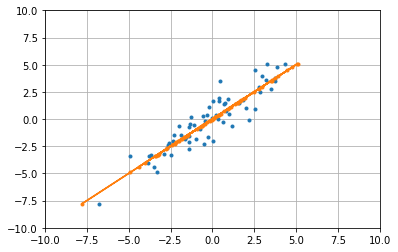

In [7]:
# check the data (noisy y vs mean prediction)
plt.plot(xs[:,0] + 2 * xs[:,1], ys, marker = '.', linestyle = 'none')
plt.plot(ys, ys, marker = '.', label = 'y=x')
plt.xlim(-10.0, 10.0)
plt.ylim(-10.0, 10.0)
plt.grid()


0 0.0
5 0.12
10 0.25
15 0.38
20 0.5
25 0.62
30 0.75
35 0.88
40 1.0
45 1.12
50 1.25
55 1.38
60 1.5
65 1.62
70 1.75
75 1.88


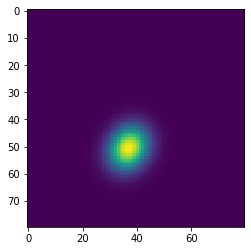

In [8]:
import matplotlib.pyplot as plt                       

# evaluate likelihood on grid
im = np.zeros([80, 80])

gxs = np.arange(0.0, 2.0, 0.025)
gys = np.arange(1.0, 3.0, 0.025)
for xi, x in enumerate(gxs):
    if (xi % 5) == 0:
        print(xi,round(x,2))
    for yi,y in enumerate(gys):
        state = LinearScalar(torch.tensor([x,y]))
        im[xi,yi] = ufn(state, list(range(64))).item()


plt.imshow(np.exp(im - im.max()))

In [9]:
# Run MALA HINTS and check unbiased likelihood

In [44]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults


if True:
    args.levels = 3
    args.design = np.array([1, 4, 4, 4])
    aa = False
    sd = 0.1
else:
    args.levels = 0
    args.design = np.array([64])
    NUM_SCENARIOS = args.design.prod()
    aa = False
    sd = 1.0
    
NUM_SCENARIOS = args.design.prod()

print(NUM_SCENARIOS)

# design now has levels + 1 entries: so we can give a minibatch size in design[0]
# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)
args.epsilon = 0.05 # for HMC
args.L = 4
print(args.__dict__)





64
{'levels': 3, 'design': array([1, 4, 4, 4]), 'additive': True, 'T': 1.0, 'dT': 0.0, 'epsilon': 0.05, 'L': 4}


In [45]:
# test that we have a true Hamiltonian (as epsilon gets small prob accept tends to 1)
# (test for L=1 and L>1)
import copy
torch.manual_seed(0)
args2 = copy.deepcopy(args)
#args2.epsilon /= (100 * args.L) # do this to make Hamiltonian more precise
print(args2.epsilon)
g = TorchLinearScalar(xs, ys)
hmc_test = HINTS_HMC(args2, g, noise_sd = 1.0) # noise sd is now ignored
state = g.sample_initial_state()
print(hmc_test.ns)
print(hmc_test.scenarios(0, 0))
state, correction = hmc_test.primitive_move(state, index = 0, always_accept = False, verbose =  True)
print(state.mu, correction)

0.05
2 64 1 64
RESET
3
[ 1  4 16 64]
64
[1. 1. 1. 1.]
[ 1  4 16 64]
[0]
1
0
gradient =  tensor([0.6623, 0.1325])
initial correction =  -1.2303847641796768
momentum =  tensor([ 1.5576, -0.2901])
proposal =  tensor([ 0.0779, -0.0145])
updated:
Parameter containing:
tensor([ 0.0779, -0.0145], requires_grad=True)
counter 1
momentum after second half step =  tensor([ 1.5737, -0.2869])
running correction =  tensor(0.0490)
l =  0
v =  -0.9338928648591354 v_prime =  -0.8848964641916319 vdiff =  0.04899640066750344 correction =  -1.2303847641796768
p(accept) =  3.5944146870121165
1
gradient =  tensor([0.6447, 0.1290])
momentum =  tensor([ 1.5898, -0.2837])
proposal =  tensor([ 0.1574, -0.0287])
updated:
Parameter containing:
tensor([ 0.1574, -0.0287], requires_grad=True)
counter 2
momentum after second half step =  tensor([ 1.6055, -0.2805])
running correction =  tensor(0.0977)
l =  1
v =  -0.9338928648591354 v_prime =  -0.8361694294180219 vdiff =  0.0977234354411135 correction =  -1.2303847641

In [46]:
g = TorchLinearScalar(xs, ys)
hmc = HINTS_HMC(args, g, noise_sd = sd) # noise sd crucial for acceptance rate (check maths for sd not equal to 1
state  = g.sample_initial_state()
print(state.mu)

2 64 1 64
RESET
3
[ 1  4 16 64]
64
[1. 1. 1. 1.]
Parameter containing:
tensor([0., 0.], requires_grad=True)


In [47]:
t = 0
time0 = time.time()
now = time0
samp = []
run_time_mins = 15
while (now < (time0 + 60.0 * run_time_mins)):
    hmc.shuffle()
    #print(t)
    #g.evaluate.cache_clear() # risk of revisiting same state and scenario after reject, and gradient not being available
    state, correction = hmc.hints(state, args.levels, always_accept = aa) # e.g. dbg = (t==0)
    samp.append(state.mu.detach())
    t+=1
    now = time.time()
    if (t%100) == 0:
        print("Iteration:{}   Time taken:{}".format(t, round(now - time0, 2)), hmc.acceptances, hmc.rejections)
        print(state.mu)

# print time per evaluation
for (a,r) in zip(hmc.acceptances, hmc.rejections):
    print(a,r, round((a * 100)/(a+r), 2), "%")


Iteration:100   Time taken:25.01 [5845 1553  337   61] [555  47  63  39]
Parameter containing:
tensor([1.3491, 1.9283], requires_grad=True)
Iteration:200   Time taken:47.85 [11736  3097   689   126] [1064  103  111   74]
Parameter containing:
tensor([1.2320, 1.8356], requires_grad=True)
Iteration:300   Time taken:70.91 [17665  4646  1030   188] [1535  154  170  112]
Parameter containing:
tensor([1.1836, 2.0091], requires_grad=True)
Iteration:400   Time taken:93.81 [23590  6186  1377   253] [2010  214  223  147]
Parameter containing:
tensor([1.0121, 2.0310], requires_grad=True)
Iteration:500   Time taken:119.55 [29534  7729  1724   302] [2466  271  276  198]
Parameter containing:
tensor([1.2914, 1.9941], requires_grad=True)
Iteration:600   Time taken:145.5 [35513  9262  2077   363] [2887  338  323  237]
Parameter containing:
tensor([1.2471, 1.6012], requires_grad=True)
Iteration:700   Time taken:167.93 [41440 10810  2436   417] [3360  390  364  283]
Parameter containing:
tensor([1.0637,

In [48]:
# scatter the sample
allsamp = torch.stack(samp)


In [49]:
ns = allsamp.shape[0]
print(ns)

3687


Text(0.5, 1.0, 'Zoomed')

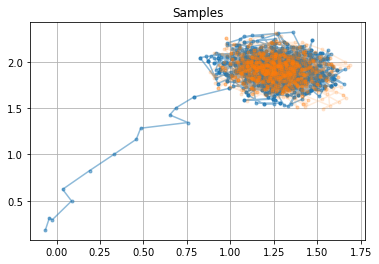

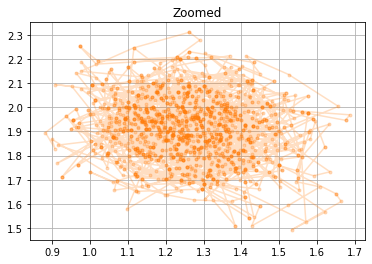

In [50]:
plt.plot(allsamp[:ns//2,0].numpy(), allsamp[:ns//2,1].numpy(), alpha = 0.5, marker = '.', label = 'first half of run')
plt.plot(allsamp[ns//2:,0].numpy(), allsamp[ns//2:,1].numpy(), alpha = 0.15, marker = '.', label = 'second half of run')
plt.grid()
plt.title("Samples")

plt.figure()
next(plt.gca()._get_lines.prop_cycler) 
plt.plot(allsamp[ns//2:,0].numpy(), allsamp[ns//2:,1].numpy(), alpha = 0.25, marker = '.')
plt.grid()
plt.title("Zoomed")

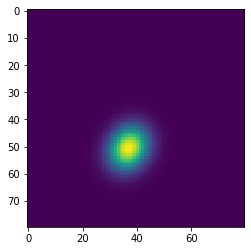

In [51]:
ime = np.exp(im - im.max())
plt.imshow(ime)

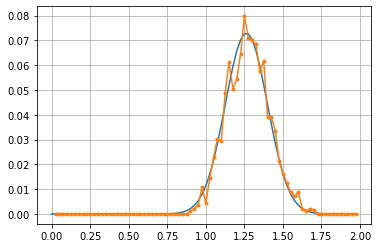

In [52]:
exh = ime.sum(axis = 1)
exh/=exh.sum()
plt.plot(gxs, exh)

# get histograms of marginals? compare with MCMC?
# or analytical posterior... 

counts, edges = np.histogram(allsamp[ns//2:,0], bins = gxs)

plt.plot(edges[1:], counts/float(np.sum(counts)), marker = '.')
plt.grid()


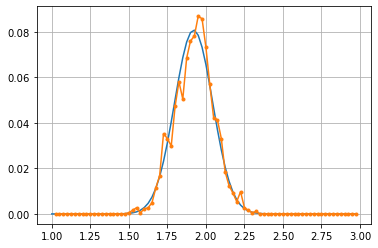

In [53]:
exh = ime.sum(axis = 0)
exh/=exh.sum()
plt.plot(gys, exh)

# get histograms of marginals? compare with MCMC?
# or analytical posterior... 

counts, edges = np.histogram(allsamp[ns//2:,1], bins = gys)

plt.plot(edges[1:], counts/float(np.sum(counts)), marker = '.')
plt.grid()


## Original Logistic Regression example (image recognition)

In [55]:
# first test PyTorch
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
batch_size = 100
#train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
# Example PyTorch model
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x) # pytorch Crossentropy loss takes scores, not logits as inputs
        #outputs = F.softmax(self.linear(x), dim = -1) # why better without F.softmax
        return outputs 

In [57]:
# was not worth caching this
def get_minibatch(dataset, n, i, input_dim = 784):
    lst1, lst2 = zip(*[dataset[ii] for ii in range(i * n, (i+1) * n)])
    xs = torch.stack(lst1).view(-1, input_dim)
    ys = torch.tensor(lst2)
    return(xs, ys)

In [58]:
%%time
input_dim = 784
output_dim = 10

# Note we will use a Bayesian model average of (some distribution over) history of sampled class probs in the sampling case
criterion = torch.nn.CrossEntropyLoss(reduction = 'sum') # computes softmax and then the cross entropy
model = LogisticRegression(input_dim, output_dim)
lr_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate) # SToch Gdt Descent
N = train_dataset.__len__()//batch_size # TO DO: get N from dataset
print(N)
epochs = 4 #n_iters / (len(train_dataset) / batch_size)
i = 0
for epoch in range(int(epochs)):
    epoch_losses = []
    for it in range(N):
        optimizer.zero_grad()
        images, labels = get_minibatch(train_dataset, batch_size, it)    
        outputs = model(images)
        loss = criterion(outputs, labels) # NEXT STEP: replace with an evaluate call!!!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.detach().item())
        i += 1
    # end of epoch: calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28))
        outputs = model(images)
        # TO DO convert these outputs to probs, to get more accurate Accuracy metric
        # and to support historical averaging (e.g. q(n) = p(n) * 2/(n+1) + q(n-1) * (n-1)/(n+1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * float(correct)/total
    print("Iteration: {}. Loss: {:1f}. Accuracy: {}.".format(i, torch.tensor(epoch_losses).mean(), accuracy))

600
Iteration: 600. Loss: 53.570171. Accuracy: 90.23.
Iteration: 1200. Loss: 35.971049. Accuracy: 91.04.
Iteration: 1800. Loss: 33.167354. Accuracy: 91.37.
Iteration: 2400. Loss: 31.699809. Accuracy: 91.62.
Wall time: 54.6 s


In [59]:
# Create the user function for HINTS


device = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU slightly reduces minibatch wall clock time (100)

class TorchMNIST(UserFn):
        def __init__(self, additive = True):
            self.batch_size = 100 # 60000 dataset size (so will not see many GPU benefits)
            self.input_dim = 784
            self.output_dim = 10
            self.train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
            self.N = self.train_dataset.__len__()//self.batch_size # num scenarios
            self.lr = 0.001 # TO DO pass this parameter
            self.additive = additive # used by HINTS
            print(self.N)
            self.criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')
            #self.calls = [] # for cache stats
            super().__init__(None)
        #
        def sample_initial_state(self):
            model = LogisticRegression(self.input_dim, self.output_dim).to(device)
            return(model)
        #    
        @lru_cache(maxsize = 1000000)
        def evaluate(self, state, term_index, gradient = False):
            #self.calls.append((hash(self), hash(state), hash(term_index), hash(gradient)))
            self.counter += 1
            if gradient:
                f = -self.minibatch_loss(state, term_index)
                f.backward()
            else:
                with torch.no_grad():
                    f = -self.minibatch_loss(state, term_index)
            return(f)
        #
        # this can be called with or without torch.no_grad
        def minibatch_loss(self, model, term_index):
            images, labels = get_minibatch(self.train_dataset, self.batch_size, term_index)  
            outputs = model(images.to(device))
            loss = self.criterion(outputs.cpu(), labels) # NEXT STEP: replace with an evaluate call!!!
            return(loss)



In [60]:
# test it   
MH = TorchMNIST()
state0 = MH.sample_initial_state()
state1 = state0
%time v = MH.evaluate(state0, 6, True)
%time v = MH.evaluate(state1, 6, True) # cached: should be faster
print(v)
for f in state0.parameters():
    print(f.shape, f.grad.shape)

600
Wall time: 20 ms
Wall time: 0 ns
tensor(-230.0949, grad_fn=<NegBackward0>)
torch.Size([10, 784]) torch.Size([10, 784])
torch.Size([10]) torch.Size([10])


In [61]:
%%time
# MINIBATCH SGD EXAMPLE (no HINTS yet)
epochs = 4
lr_rate = 0.001
model = MH.sample_initial_state()
optimizer = torch.optim.SGD(model.parameters(), lr = lr_rate)
i = 0
for epoch in range(int(epochs)):
    epoch_losses = []
    for it in range(MH.N):
        optimizer.zero_grad()
        loss = MH.minibatch_loss(model, it).cpu()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.detach().item())
        i += 1
    # end of epoch: calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28))
        outputs = model(images.to(device)).cpu()
        # TO DO convert these outputs to probs, to get more accurate Accuracy metric
        # and to support historical averaging (e.g. q(n) = p(n) * 2/(n+1) + q(n-1) * (n-1)/(n+1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * float(correct)/total
    print("Iteration: {}. Loss: {:1f}. Accuracy: {}.".format(i, torch.tensor(epoch_losses).mean(), accuracy))



Iteration: 600. Loss: 53.494258. Accuracy: 90.12.
Iteration: 1200. Loss: 35.948849. Accuracy: 90.95.
Iteration: 1800. Loss: 33.149333. Accuracy: 91.29.
Iteration: 2400. Loss: 31.684898. Accuracy: 91.6.
Wall time: 56.8 s


In [97]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults


if True: # set to True for HINTS
    args.levels = 6
    log_branch_factor = 1
    N_0 = 1
    args.design = np.array([1,2,3,2,5,2,5])
    NUM_SCENARIOS = args.design.prod()
    aa = False
    sd = 1.0
elif True: # test Langevin MCMC first (or set sd to small value for SGD)
    args.levels = 1 
    NUM_SCENARIOS = 600 # Langevin / SGD
    args.design = np.array([1,NUM_SCENARIOS]) # ensure whole dataset is covered
    aa = True # use always_accept flag to get minibatch Langevin (so we actually only have  a 1 level architecture) - TOP LEVEL ALWAYS ACCEPT
    sd = 0.001
else: # FULL DATASET (not minibatch) Langevin/gradient descent
    args.levels = 0 
    NUM_SCENARIOS = 600 # 600 for naive mcmc, 1 for SGD
    args.design = np.array([NUM_SCENARIOS]) # ensure whole dataset is covered
    aa = True # always accept only applies to TOP LEVEL
    sd = 0.001
    
print(NUM_SCENARIOS)

# design now has levels + 1 entries: so we can give a minibatch size in design[0]
# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)
args.epsilon = 0.001 # for HMC
args.L = 1 # HMC steps
print(args.__dict__)


g = TorchMNIST(args.additive)
hmc = HINTS_HMC(args, g, noise_sd = sd) # noise sd crucial for acceptance rate (check maths for sd not equal to 1
state  = g.sample_initial_state()
print(state)



600
{'levels': 6, 'design': array([1, 2, 3, 2, 5, 2, 5]), 'additive': True, 'T': 1.0, 'dT': 0.0, 'epsilon': 0.001, 'L': 1}
600
RESET
6
[  1   2   6  12  60 120 600]
600
[1. 1. 1. 1. 1. 1. 1.]
LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [98]:
# test that we have a true Hamiltonian (as epsilon gets small prob accept tends to 1)
# (test for L=1 and L>1)
import copy
torch.manual_seed(0)
args2 = copy.deepcopy(args)
args2.epsilon /= (100 * args.L) # do this to make Hamiltonian more precise
print(args2.epsilon)
g = TorchMNIST(args.additive)
hmc_test = HINTS_HMC(args2, g, noise_sd = 1.0) # noise sd is now ignored
state = g.sample_initial_state()
print(hmc_test.ns)
print(hmc_test.scenarios(0, 0))
state, correction = hmc_test.primitive_move(state, index = 0, always_accept = False, verbose =  True)
print(correction)

1e-05
600
RESET
6
[  1   2   6  12  60 120 600]
600
[1. 1. 1. 1. 1. 1. 1.]
[  1   2   6  12  60 120 600]
[0]
1
0
gradient =  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
initial correction =  -3939.285520121741
momentum =  tensor([[ 0.1571, -0.0740, -0.3431,  ...,  0.3503,  0.5977, -0.5300],
        [ 0.3233,  1.8814,  0.8823,  ..., -0.3382,  0.4039,  0.3145],
        [ 0.9249,  0.3335,  1.0188,  ...,  0.6947, -0.3591, -0.0235],
        ...,
        [-0.0408,  0.4031, -1.5479,  ...,  0.2294, -0.7482, -0.4704],
        [-0.0570,  0.7583, -0.2993,  ...,  1.9096,  0.3542,  0.1955],
        [ 0.1193,  0.3190,  0.6423,  ..., -0.6517, -0.8339, -1.6995]])
proposal =  tensor([[ 0.0336,  0.0148, -0.0029,  ..., -0.0143, -0.0238, -0.0120],
        [ 0.0174, -0.0162,  0.0356,  ...,  0.0019, -

In [99]:
t = 0
time0 = time.time()
print(time0)
now = time0
then = now
while (now < (time0 + 3600.0)):
    hmc.shuffle()
    print(t)
    g.evaluate.cache_clear() # risk of revisiting same state and scenario after reject, and gradient not being available [NOT NEEDED?? IF ALWAYS EVAL WITH GDT]
    state, correction = hmc.hints(state, args.levels, always_accept = aa) # e.g. dbg = (t==0)
    # diagnostic histogram
    # show progress
    prev_then = then
    then = time.time()
    t+=1
    if True:
        with torch.no_grad():
            loss = MH.minibatch_loss(state, (t-1) % NUM_SCENARIOS)
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = Variable(images.view(-1, 28*28))
            outputs = state(images.to(device))
            # TO DO convert these outputs to probs, to get more accurate Accuracy metric
            # and to support historical averaging (e.g. q(n) = p(n) * 2/(n+1) + q(n-1) * (n-1)/(n+1))
            _, predicted = torch.max(outputs.cpu().data, 1)
            total += labels.size(0)
            # for gpu, bring the predicted and labels back to cpu fro python operations to work
            correct+= (predicted == labels).sum()
        accuracy = 100 * float(correct)/total
        prev_now = now
        now = time.time()
        print("Iteration: {}. Train time:{}. Test time:{}. Noisy loss: {}. Accuracy: {}."\
              .format(t, round(then - prev_now, 2), round(now - then, 2), round(loss.item(),2), accuracy), hmc.acceptances, hmc.rejections)
    else:
        now = time.time()
        print("Iteration: {}. Time taken:{}."\
              .format(t, round(then - prev_then, 2), hmc.acceptances, hmc.rejections))

# print time per evaluation
hmc.acceptances.sum()


1717675771.2967598
0
Iteration: 1. Train time:123.78. Test time:1.83. Noisy loss: 220.54. Accuracy: 17.34. [579 278  81  41  10   5   1] [21 22 19  9  0  0  0]
1
Iteration: 2. Train time:111.38. Test time:1.82. Noisy loss: 218.26. Accuracy: 25.7. [1165  558  167   83   20   10    2] [35 42 33 17  0  0  0]
2
Iteration: 3. Train time:117.28. Test time:1.92. Noisy loss: 205.11. Accuracy: 34.32. [1740  839  253  127   29   15    3] [60 61 47 23  1  0  0]
3
Iteration: 4. Train time:113.68. Test time:1.83. Noisy loss: 193.44. Accuracy: 40.04. [2330 1119  332  164   38   20    4] [70 81 68 36  2  0  0]
4
Iteration: 5. Train time:114.25. Test time:1.9. Noisy loss: 189.83. Accuracy: 47.26. [2911 1399  412  207   48   25    5] [ 89 101  88  43   2   0   0]
5
Iteration: 6. Train time:119.83. Test time:1.95. Noisy loss: 193.87. Accuracy: 51.31. [3493 1682  496  254   58   30    6] [107 118 104  46   2   0   0]
6
Iteration: 7. Train time:117.0. Test time:1.96. Noisy loss: 183.4. Accuracy: 54.4. [40

32378

In [100]:
# NB steps are too small if we are not seeing occasional rejection at root - params would need tuning

In [101]:
# cache making no difference
print(g.total_counter, g.counter, "miss% = " + str(int((100.0 * g.counter)/ g.total_counter))) # check cache ratio
#(len(set(g.calls)), len(g.calls)) # check potential gain from cache

2 2 miss% = 100


In [102]:
g.evaluate.cache_info()

CacheInfo(hits=2350, misses=6050, maxsize=1000000, currsize=6050)

In [ ]:
# looks to be better than MCMC [but for this dataset, no compelling case for MCMC methods]
# HOW MUCH NOISE AT PRIMITIVE LEVEL? - zero case for SGD
# aim for bigger moves at primitive level (or HMC chain?)
# GPU - DONE
# Bayesian accuracy measure e.g thru decaying average (triangle distrib)
